# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Loading the Data

In [2]:
SEED = 123 # For reprodicibility
IMG_SIZE = (224, 224)

# ----- Creating a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.utils.image_dataset_from_directory(
    directory='../datasets/train',
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=32,
)
# ----- Creating a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='../datasets/test', 
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
)

# ----- Creating a validation dataset object (tf.data.Dataset)----- #
val_set = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='../datasets/validation',
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
)

Found 1034 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


# Visualizing Samples from Dataset

In [3]:
# Category list
class_names = train_set.class_names

# Visualizing samples from the training set
class_images = {cat: [] for cat in class_names}

for image, label in train_set.unbatch():
    cat = class_names[np.argmax(label.numpy())]
    # Take 5 images per class
    if len(class_images[cat]) < 5:
        class_images[cat].append(image.numpy())
    if all(len(images) >= 5 for images in class_images.values()):
        break

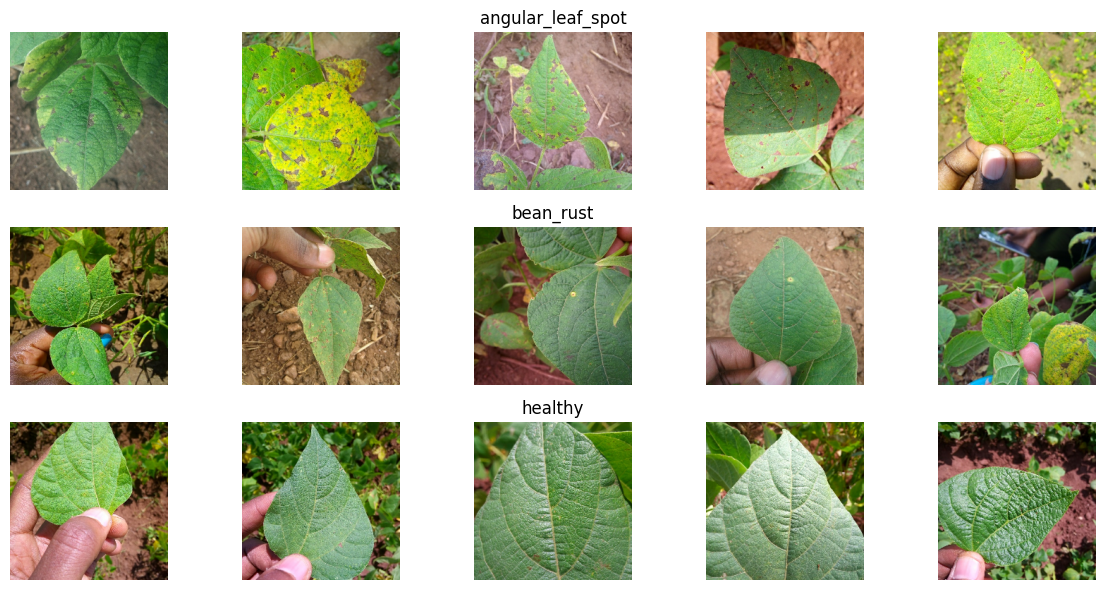

In [4]:
# Function for plotting the sample images
def plot_images(cnames: list, cimages: dict):
    fig, axes = plt.subplots(len(cnames), 5, figsize=(12, 6))

    for i, cat in enumerate(cnames):
        for j in range(5):
            if j < len(cimages[cat]):
                ax = axes[i, j]
                ax.imshow(cimages[cat][j] / 255.) # /255. to normalize RGB values of image
                # Turn off ticks for better display
                ax.axis('off')
                # Placing category name at middle image
                if j == 2:
                    ax.set_title(cat) 
    plt.tight_layout()
    # plt.savefig('../images/dataset_prev.png')
    plt.show()

# Plot the images
plot_images(class_names, class_images)

# CNN Model Creation and Training

## Creating the Model

In [5]:
# Function for creating network architecture
def create_cnn(input_shape: tuple) -> any:
    model = tf.keras.Sequential()
    # Add an input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Convolutional blocks
    ## Block 1
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 2
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 3
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 4
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 5
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    # ## Block 6
    # model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    # ## Block 7
    # model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    # model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))


    # Global Average Pooling layer
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    # Dense (fully connected) blocks
    model.add(tf.keras.layers.Dense(units=32, kernel_regularizer='l2', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=16, kernel_regularizer='l2', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    # Output layer
    model.add(tf.keras.layers.Dense(units=len(train_set.class_names), activation='softmax'))

    return model

In [6]:
beanCNN = create_cnn(
    input_shape=(224, 224, 3)
)
beanCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 16)       0

## Compiling the Model

In [7]:
beanCNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/best_beanCNN.h5', monitor='val_accuracy', save_best_only=True)
]

## Training the Model on the Training Set

In [8]:
beanCNN_history = beanCNN.fit(
    train_set, 
    validation_data=val_set,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50


33/33 [==============================] - 6s 59ms/step - loss: 2.5916 - accuracy: 0.3491 - val_loss: 1.6211 - val_accuracy: 0.5263
Epoch 2/50
33/33 [==============================] - 1s 39ms/step - loss: 1.6339 - accuracy: 0.3665 - val_loss: 1.5617 - val_accuracy: 0.4737
Epoch 3/50
33/33 [==============================] - 2s 40ms/step - loss: 1.4762 - accuracy: 0.4652 - val_loss: 1.3652 - val_accuracy: 0.5940
Epoch 4/50
33/33 [==============================] - 2s 41ms/step - loss: 1.4223 - accuracy: 0.4691 - val_loss: 1.4378 - val_accuracy: 0.5639
Epoch 5/50
33/33 [==============================] - 1s 39ms/step - loss: 1.3691 - accuracy: 0.4942 - val_loss: 1.2383 - val_accuracy: 0.5639
Epoch 6/50
33/33 [==============================] - 2s 41ms/step - loss: 1.3407 - accuracy: 0.4729 - val_loss: 1.2589 - val_accuracy: 0.6466
Epoch 7/50
33/33 [==============================] - 1s 40ms/step - loss: 1.2915 - accuracy: 0.5184 - val_loss: 1.2446 - val_accuracy: 0.5414
Epoch 8/50
33/33 [======

# Model Evaluation

In [9]:
# Function to predict categories
def predict_cats(model, dataset) -> dict:
    prediction = {}
    # Getting the true values
    true_vals_encoded = np.concatenate([label for img, label in dataset], axis=0)
    true_vals = np.argmax(true_vals_encoded, axis=-1)
    # Add true values to the dictionary
    prediction['true'] = true_vals
    # Probability of classes
    pred_prob = model.predict(dataset)
    # Getting the predicted values
    pred_vals = np.argmax(pred_prob, axis=-1)
    # Add predicted values to the dictionary
    prediction['pred'] = pred_vals

    return prediction

# Function to plot training curves
def plot_curves(history: dict):

    plt.figure(figsize=(15, 5))

    # Plot training and validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.suptitle('Model Training performance') 
    plt.show()

# Function to show model performance evaluation
def show_eval_(model, dataset: list):
    # Dictionary of true and predicted values from the dataset
    for _set in dataset:
        prediction = predict_cats(model=model, dataset=_set)

        plt.figure(figsize=(10, 7)) 
        # Confusion matrix 
        ax = sns.heatmap(confusion_matrix(prediction['true'], prediction['pred']), annot=True, xticklabels=_set.class_names , yticklabels=_set.class_names)
        ax.set_title('Confusion Matrix')
        plt.show()

        print("\n\nClassification Report:\n")
        print(classification_report(prediction['true'], prediction['pred'], target_names=_set.class_names))


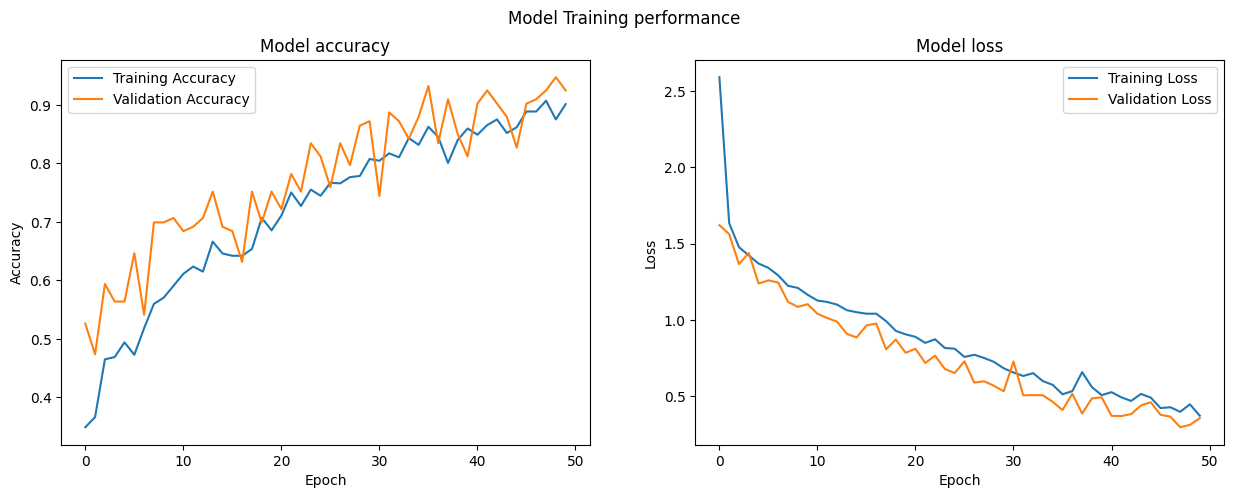

In [10]:
# ----- Show training (loss and accuracy) curves during the model training process ----- #
plot_curves(beanCNN_history.history)

4/4 [==============================] - 0s 26ms/step


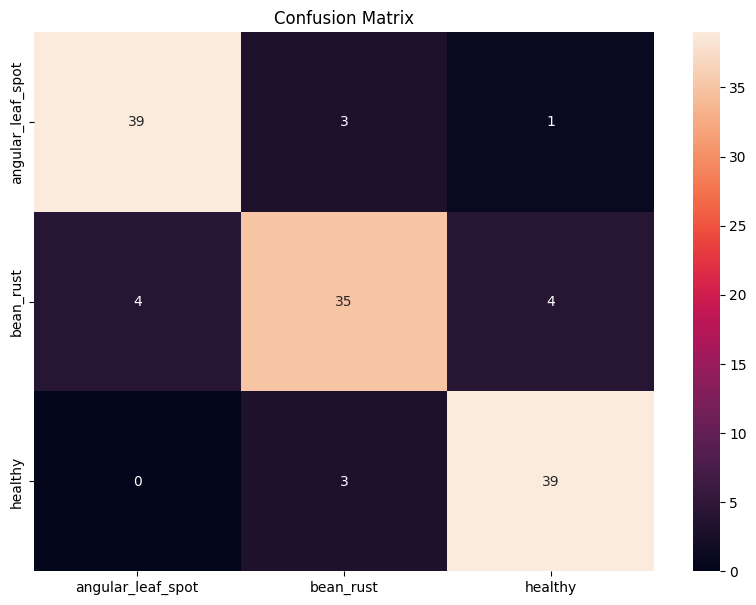



Classification Report:

                   precision    recall  f1-score   support

angular_leaf_spot       0.91      0.91      0.91        43
        bean_rust       0.85      0.81      0.83        43
          healthy       0.89      0.93      0.91        42

         accuracy                           0.88       128
        macro avg       0.88      0.88      0.88       128
     weighted avg       0.88      0.88      0.88       128



In [11]:
# Loading best model from directory
best_model = tf.keras.models.load_model('../models/best_beanCNN.h5')  
# Show model evaluation
show_eval_(model=best_model, dataset=[test_set])